# **Indonesia Case Study 🇮🇩**

Our research examines Indonesia’s long-term economic development by focusing on the roles of capital accumulation, saving, population growth, and research and development. Institutional and cultural factors, though potentially important, are not considered in this analysis to maintain a clear focus on these key economic drivers.

This notebook serves as the coding part of the project, aiming to answer key questions related to Indonesia's economic development using provided data. It includes:

1. **Trend Calculation**: Analyses the trends for the natural logarithms of real GDP and real GDP per capita at constant 2017 national prices, with robustness checks using levels instead of log levels.

2. **Total Factor Productivity (TFP) Measure**: Derives TFP using a production function, considering real GDP, the number of employed workers, and the capital stock, while testing robustness with alternative values for the production parameter alpha.

3. **Growth Accounting**: Breaks down the contributions of input variables to changes in GDP, focusing on long-run developments rather than yearly averages.

4. **Labour Productivity**: Constructs a series for GDP per worker to study labour productivity trends.




## **1. Import Modules ⚙️** 
Load essential libraries and custom functions for data analysis and visualisation.

In [1]:
# Import modules

import numpy as np
import pandas as pd # import library for data analysis

from get_regression_coefs_general import get_regression_coefs # import our function to get GDP trend

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns # for nicer plots (not essential)
sns.set_theme('talk', style = 'white')

import openpyxl

## **2. Data Loading and Cleaning 📈** 
We load and clean the data for our analysis in the later section.

In [2]:
# Load dataset
data = pd.read_excel('pwt100.xlsx', sheet_name = 'Data', header = 0)

In [3]:
# Clean data

# Subset relevant columns and compute per capita real GDP
# The .loc property is used for indexing; see here for more https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html
data = data.loc[:, ("country", "year", "rgdpna", "pop")]
data["rgdpe_pc"] = data["rgdpna"] / data["pop"]

# select Indonesia
data = data.loc[data["country"] == "Indonesia", ("year", "rgdpe_pc")]
# Reset the index (not crucial)
data = data.reset_index(drop = True)

# Calculate number of years before removing NaN values 
years_before = len(data)

# Filter out rows with missing values for per capita GDP
data = data.dropna(subset=["rgdpe_pc"])

# Calculate number of years after removing NaN values 
years_after = len(data)
years_removed = years_before - years_after

# Subset the RGDP per capita series
ymax = 2019
ymin = 1950
# We use logical indexing to subset the data to rows of years ymin <= year <= ymax
Y = data.loc[np.logical_and(data["year"] <= ymax, data["year"] >= ymin), "rgdpe_pc"]
y = np.log(Y)
data = data[data["year"] >= ymin] # we keep only years after ymin

# Compute separate sample sizes for the subsample used for estimation and the whole sample.
T = len(Y) # sample size used for regression
T_all = data["year"].max() - (ymin - 1) - years_removed # number of all years in the data after ymin that have data points

# Print the sample sizes
print(f"The sample size of our data is {T}")
print(f"The total number of years with data after ymin is {T_all}")


The sample size of our data is 60
The total number of years with data after ymin is 60


## **3. Project Tasks Overview**

- **3.1   Trend Calculation**:  Analyse trends for real GDP and GDP per capita (logarithms and levels) using constant 2017 national prices.

- **3.2  TFP Measure**:         Extract Total Factor Productivity using real GDP, employment, capital stock, and optionally the human capital index.

- **3.3  Growth Accounting**:   Decompose GDP growth contributions, focusing on long-term trends.

- **3.4  Labour Productivity**: Create a time series for GDP per worker.

### **3.1 Trend Calculation**

We analyse GDP trends using four different models to understand their fit and performance:

**3.1.1 Additive + Linear**

**3.1.2 Additive + Quadratic**

**3.1.3 Exponential + Linear**

**3.1.4 Exponential + Quadratic**


### **3.1.1 Linear Additive**

   A simple linear trend fitted to the natural logarithm of GDP.

![additive linear.png](<attachment:additive linear.png>)


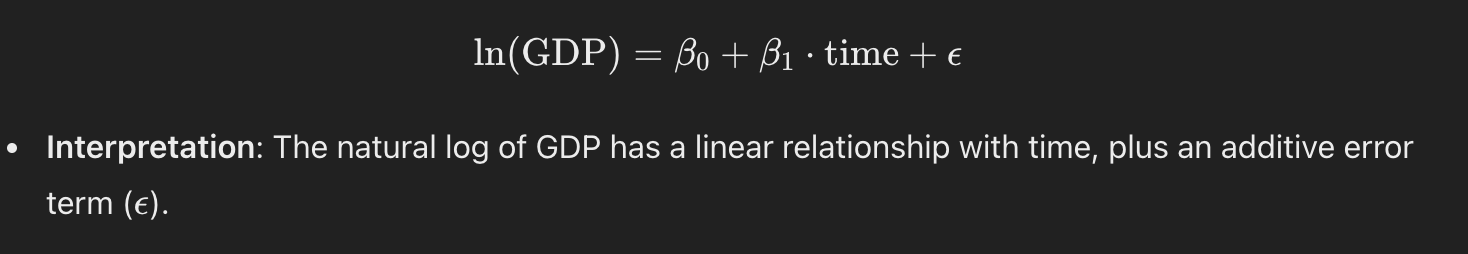

In [4]:
# Additive Linear Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
# The dependent variable is per capita GDP in *levels*

x1 = np.empty(T) # initialise an empty vector for the first regressor
x2 = np.empty(T) # initialise an empty vector for the second regressor

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1 # recall that Python starts indexing at 0

a_add_lin, b_add_lin = get_regression_coefs(Y, x1, x2)
print(a_add_lin)
print(b_add_lin)

# Initialise predicted values yhat
Yhat_add_lin = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_add_lin[t] = a_add_lin + b_add_lin * (t + 1) # recall that Python indexing starts at 0
 
# Let us convert into log-units
yhat_add_lin = np.log(Yhat_add_lin)

-93.83172831619453
159.3352245804634


### **3.1.2 Additive Quadratic**

A quadratic trend fitted to the natural logarithm of GDP to account for non-linear growth patterns.

![additive quadratic.png](<attachment:additive quadratic.png>)
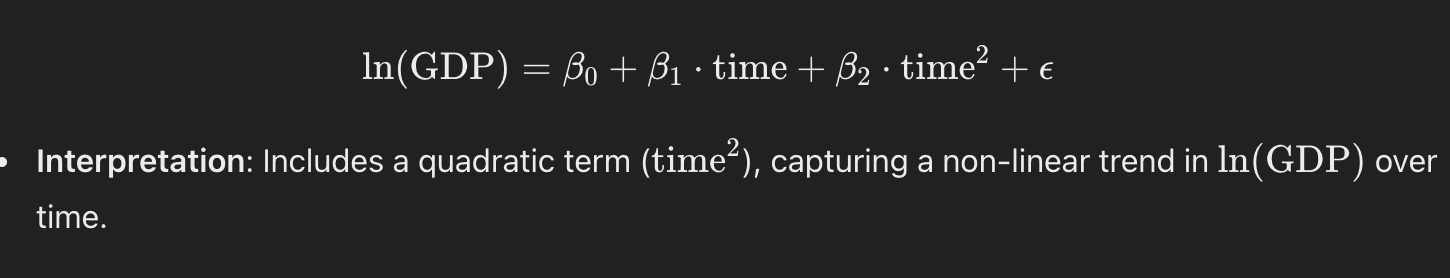

In [5]:
# Additive Quadratic Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T, third regressor x3 is the vector 1, 4, ..., T^2
# The dependent variable is per capita GDP in *levels*
x3 = x2 ** 2

a_add_quad, b1_add_quad, b2_add_quad = get_regression_coefs(Y, x1, x2, x3)

print(a_add_quad)
print(b1_add_quad)
print(b2_add_quad)

# Initialise predicted values yhat
Yhat_add_quad = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_add_quad[t] = a_add_quad + b1_add_quad * (t + 1) + b2_add_quad * (t + 1) ** 2

# Take the natural logarithm of the shifted fitted values
yhat_add_quad = np.log(Yhat_add_quad)

1500.3252810284735
5.061965611626861
2.5290698191612484


### **3.1.3 Additive Quadratic**

An exponential trend fitted to GDP data to capture compounding growth over time.

![additive quadratic.png](<attachment:additive quadratic.png>)
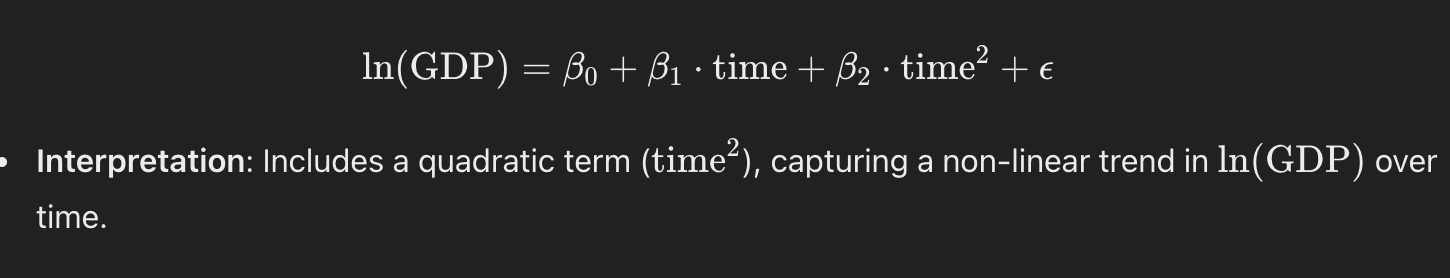

In [6]:
# Exponential Linear Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
# The dependent variable is per capita GDP in *ln*
y_exp_lin = np.log(Y)

a_exp_lin, b_exp_lin = get_regression_coefs(y_exp_lin, x1, x2)

# Initialise predicted values yhat
yhat_exp_lin = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    yhat_exp_lin[t] = a_exp_lin + b_exp_lin * (t + 1)
display(yhat_exp_lin)

array([7.20021949, 7.2367097 , 7.27319991, 7.30969013, 7.34618034,
       7.38267055, 7.41916076, 7.45565097, 7.49214118, 7.52863139,
       7.5651216 , 7.60161182, 7.63810203, 7.67459224, 7.71108245,
       7.74757266, 7.78406287, 7.82055308, 7.85704329, 7.89353351,
       7.93002372, 7.96651393, 8.00300414, 8.03949435, 8.07598456,
       8.11247477, 8.14896498, 8.1854552 , 8.22194541, 8.25843562,
       8.29492583, 8.33141604, 8.36790625, 8.40439646, 8.44088667,
       8.47737689, 8.5138671 , 8.55035731, 8.58684752, 8.62333773,
       8.65982794, 8.69631815, 8.73280836, 8.76929858, 8.80578879,
       8.842279  , 8.87876921, 8.91525942, 8.95174963, 8.98823984,
       9.02473005, 9.06122027, 9.09771048, 9.13420069, 9.1706909 ,
       9.20718111, 9.24367132, 9.28016153, 9.31665174, 9.35314196])

### **3.1.4 Exponential Quadratic**

![exponential quadratic.png](<attachment:exponential quadratic.png>)
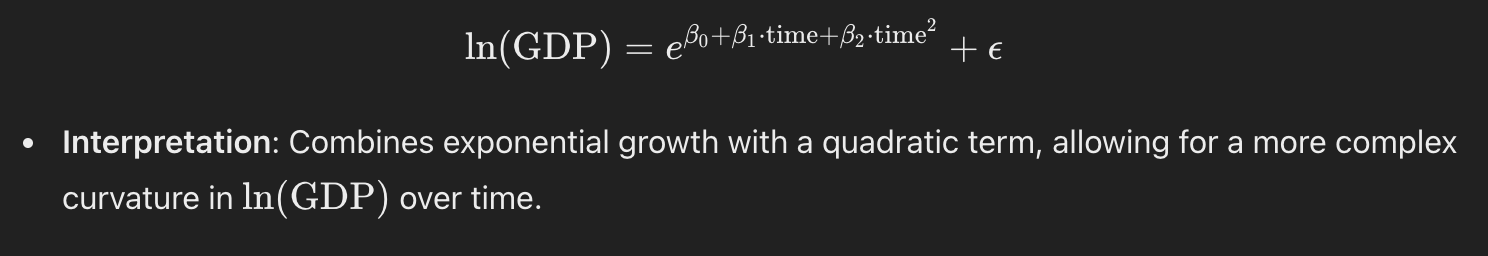

In [7]:
# Exponential Quadratic Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T, third regressor x3 is the vector 1, 4, ..., T^2
# The dependent variable is per capita GDP in *ln*
x3 = x2 ** 2

a_exp_quad, b1_exp_quad, b2_exp_quad = get_regression_coefs(y_exp_lin, x1, x2, x3)

# Initialise predicted values yhat
yhat_exp_quad = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    yhat_exp_quad[t] = a_exp_quad + b1_exp_quad * (t + 1) + b2_exp_quad * (t + 1) ** 2

display(yhat_exp_quad)

array([7.18013273, 7.21866566, 7.25712815, 7.29552021, 7.33384183,
       7.37209301, 7.41027375, 7.44838405, 7.48642391, 7.52439333,
       7.56229232, 7.60012086, 7.63787897, 7.67556664, 7.71318387,
       7.75073066, 7.78820701, 7.82561293, 7.8629484 , 7.90021344,
       7.93740804, 7.9745322 , 8.01158592, 8.0485692 , 8.08548205,
       8.12232445, 8.15909642, 8.19579794, 8.23242903, 8.26898968,
       8.30547989, 8.34189967, 8.378249  , 8.41452789, 8.45073635,
       8.48687437, 8.52294195, 8.55893909, 8.59486579, 8.63072205,
       8.66650788, 8.70222326, 8.73786821, 8.77344272, 8.80894679,
       8.84438042, 8.87974361, 8.91503637, 8.95025868, 8.98541056,
       9.02049199, 9.05550299, 9.09044355, 9.12531367, 9.16011336,
       9.1948426 , 9.22950141, 9.26408977, 9.2986077 , 9.33305519])

### **3.1.5 GDP Trends: Additive vs Exponential Models 📊**

The graphs compare GDP per capita trends using:
1. **Additive Models**:
   - Linear additive and quadratic additive trends are combined to illustrate their fit against actual GDP per capita.
2. **Exponential Models**:
   - Linear exponential and quadratic exponential trends are combined to highlight their predictive performance.

Each plot demonstrates how different models capture the historical GDP trend over time, providing insights into the fit and long-term trajectory.


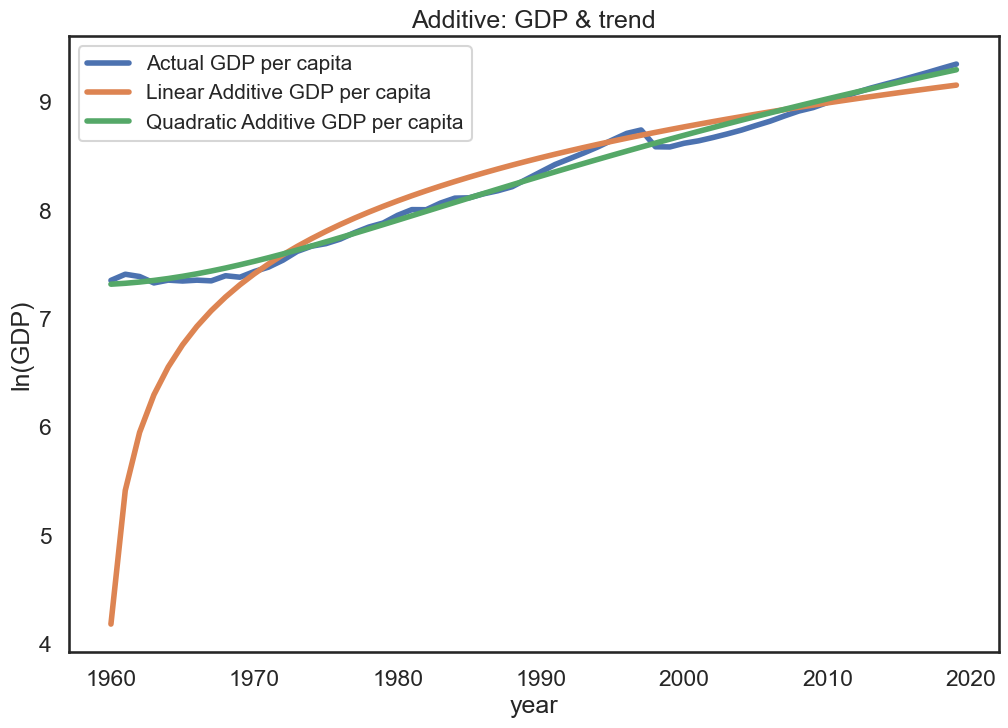

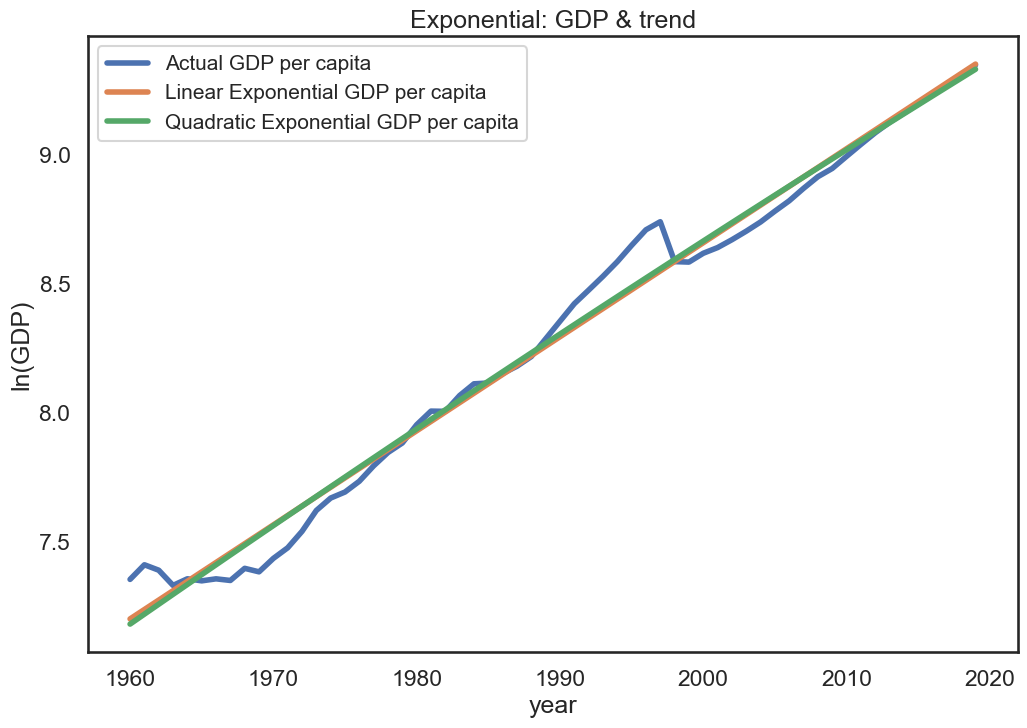

In [8]:
lw = 4

# Plot Additive Graph
plt.figure(figsize=(12, 8))  # Set the figure size to make it larger
plt.plot(data['year'], np.log(data['rgdpe_pc']), label="Actual GDP per capita", linewidth=lw)
plt.plot(data['year'], yhat_add_lin, label="Linear Additive GDP per capita", linewidth=lw)
plt.plot(data['year'], yhat_add_quad, label="Quadratic Additive GDP per capita", linewidth=lw)

# Labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")
plt.legend(fontsize='small', loc='upper left')  # Slightly larger legend font for readability

# Title
plt.title("Additive: GDP & trend")

# Show the plot
plt.show()  # Explicitly render the additive graph

# Plot Exponential Graph
plt.figure(figsize=(12, 8))  # Set the figure size for the exponential graph
plt.plot(data['year'], np.log(data['rgdpe_pc']), label="Actual GDP per capita", linewidth=lw)
plt.plot(data['year'], yhat_exp_lin, label="Linear Exponential GDP per capita", linewidth=lw)
plt.plot(data['year'], yhat_exp_quad, label="Quadratic Exponential GDP per capita", linewidth=lw)

# Labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")
plt.legend(fontsize='small', loc='upper left')  # Slightly larger legend font for readability

# Title
plt.title("Exponential: GDP & trend")

# Show the plot
plt.show()  # Explicitly render the exponential graph


### **3.2 Total Factor Productivity Measure**

The following image shows how we've decided to calculate TFP.

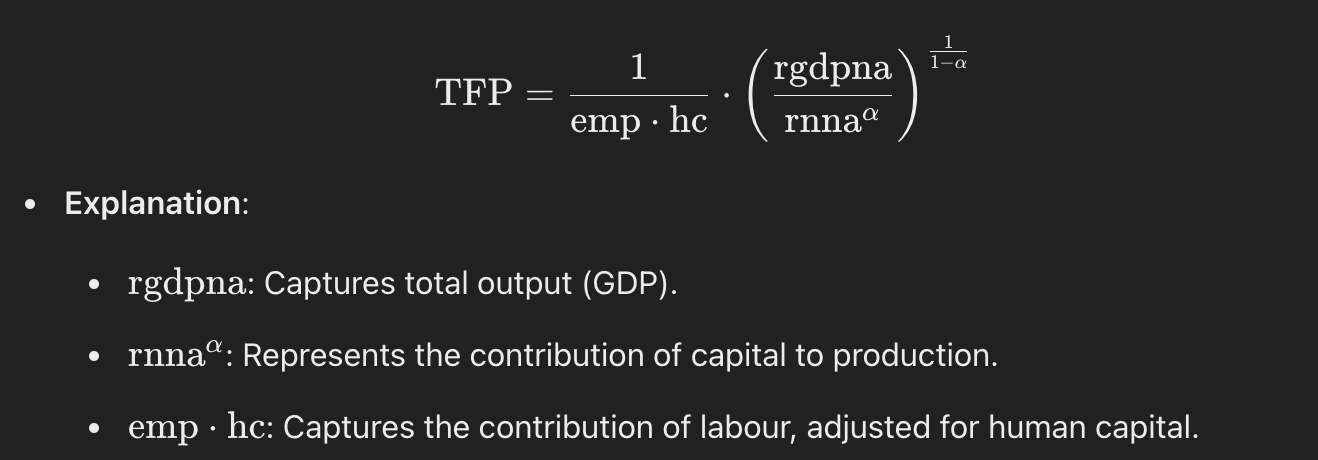

,year,rgdpna,emp,rnna,hc,TFP_alpha_0.25,TFP_alpha_0.3,TFP_alpha_0.35
0,1960,1.475389e+05,28.498953,7.623768e+05,1.158581,2584.620672,2210.380296,1845.382708
1,1961,1.596486e+05,29.060551,7.653232e+05,1.176857,2768.498671,2384.611743,2007.325066
2,1962,1.594061e+05,29.569380,7.644622e+05,1.195421,2674.185813,2303.290030,1938.785826
3,1963,1.532446e+05,30.088734,7.563245e+05,1.214278,2463.517674,2116.045162,1775.561034
4,1964,1.603702e+05,30.618654,7.516056e+05,1.233432,2537.466753,2190.323887,1848.360916
5,1965,1.622570e+05,31.159178,7.476065e+05,1.252888,2497.746395,2159.537477,1825.794865
6,1966,1.667850e+05,31.710342,7.471328e+05,1.272652,2507.069386,2173.418853,1843.225704
7,1967,1.690491e+05,32.272175,7.406710e+05,1.292727,2476.321898,2151.300857,1828.918223
8,1968,1.807467e+05,32.844719,7.435955e+05,1.313118,2615.444282,2285.829922,1956.780513
9,1969,1.818787e+05,33.427994,7.511329e+05,1.333832,2542.487892,2221.255068,1900.698727


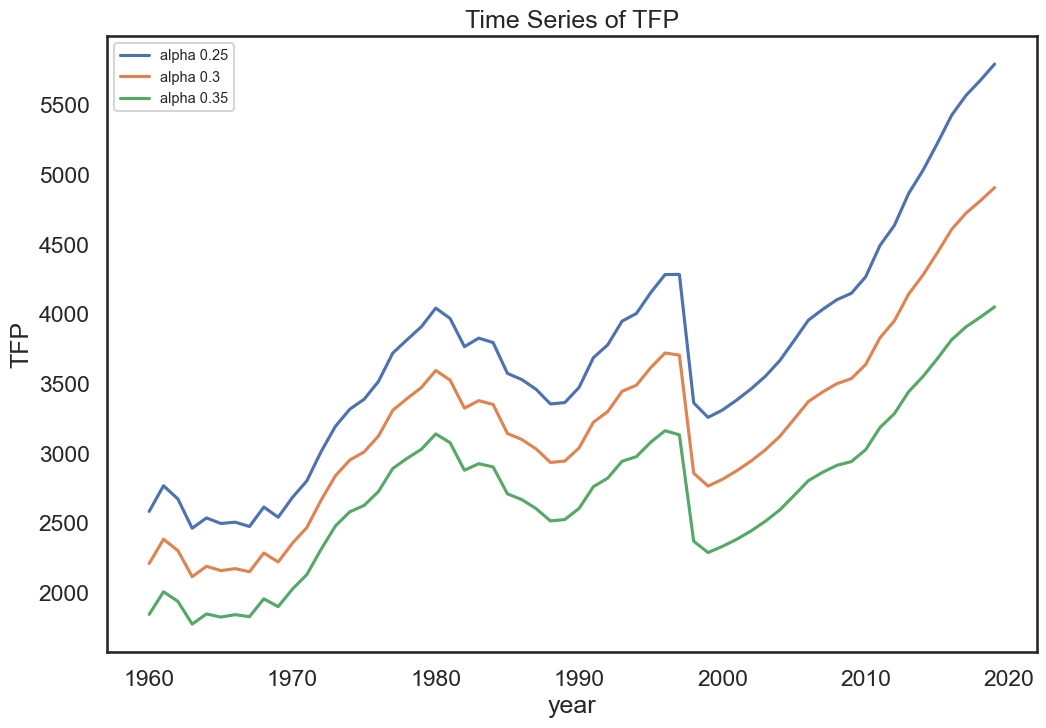

In [12]:
# Calculating TFP 

# Load dataset
data = pd.read_excel('pwt100.xlsx', sheet_name = 'Data', header = 0)

# Extract relevant variables in production function and select Indonesia
data_indonesia_b = data.loc[data["country"] == "Indonesia", ["year", "rgdpna", "emp", "rnna", "hc"]]

# Drop rows with missing values in specified columns
data_indonesia_b.dropna(subset=["rgdpna", "emp", "rnna", "hc"], inplace=True)

# Define a list of alpha values for robustness check
alpha_values = [0.25, 0.3, 0.35]

# Calculate TFP for each alpha and store the results in a dictionary
tfp_results = {}

for alpha in alpha_values:
    tfp = (1/(data_indonesia_b["emp"]*data_indonesia_b["hc"]))*(data_indonesia_b["rgdpna"]/(data_indonesia_b["rnna"])**alpha)**(1/(1-alpha))
    tfp_results[f"TFP_alpha_{alpha}"] = tfp

# Convert the results dictionary to a DataFrame for better visualization
tfp_df = pd.DataFrame(tfp_results)

# Add the year column for reference
tfp_df["year"] = data_indonesia_b["year"]

# Merge the TFP DataFrame with the original Indonesia DataFrame
data_indonesia_b = data_indonesia_b.merge(tfp_df, on="year")

# Display the updated DataFrame
display(data_indonesia_b)

# Plot Time Series
plt.figure(figsize=(12, 8))
plt.plot(data_indonesia_b['year'], data_indonesia_b["TFP_alpha_0.25"], label="alpha 0.25")
plt.plot(data_indonesia_b['year'], data_indonesia_b["TFP_alpha_0.3"], label="alpha 0.3")
plt.plot(data_indonesia_b['year'], data_indonesia_b["TFP_alpha_0.35"], label="alpha 0.35")

# Labels
plt.xlabel("year")
plt.ylabel("TFP")
plt.legend(fontsize='xx-small', loc='upper left')

# Title
plt.title("Time Series of TFP")

# Show the plot
plt.show()

### **3.3 Growth Accounting**

Calculated average growth rates for GDP, capital, labour (adjusted by human capital), and TFP over six decades. 

Proportional contributions of each input were analysed, and a time series plot was created to highlight their impact on long-term GDP growth.


,year,rgdpna,emp,rnna,hc,TFP_alpha_0.25,TFP_alpha_0.3,TFP_alpha_0.35,hL
0,1960,1.475389e+05,28.498953,7.623768e+05,1.158581,2584.620672,2210.380296,1845.382708,33.018356
1,1961,1.596486e+05,29.060551,7.653232e+05,1.176857,2768.498671,2384.611743,2007.325066,34.200116
2,1962,1.594061e+05,29.569380,7.644622e+05,1.195421,2674.185813,2303.290030,1938.785826,35.347857
3,1963,1.532446e+05,30.088734,7.563245e+05,1.214278,2463.517674,2116.045162,1775.561034,36.536083
4,1964,1.603702e+05,30.618654,7.516056e+05,1.233432,2537.466753,2190.323887,1848.360916,37.766030
5,1965,1.622570e+05,31.159178,7.476065e+05,1.252888,2497.746395,2159.537477,1825.794865,39.038974
6,1966,1.667850e+05,31.710342,7.471328e+05,1.272652,2507.069386,2173.418853,1843.225704,40.356224
7,1967,1.690491e+05,32.272175,7.406710e+05,1.292727,2476.321898,2151.300857,1828.918223,41.719104
8,1968,1.807467e+05,32.844719,7.435955e+05,1.313118,2615.444282,2285.829922,1956.780513,43.129007
9,1969,1.818787e+05,33.427994,7.511329e+05,1.333832,2542.487892,2221.255068,1900.698727,44.587325


,Y growth,K contribution,hL contribution,A contribution,K contribution proportion,hL contribution proportion,A contribution proportion
year,,,,,,,
1960-1970,0.281279,0.010385,0.830335,0.159280,0.002921,0.233556,0.044802
1970-1980,0.767951,0.245765,0.368947,0.385288,0.188735,0.283333,0.295883
1980-1990,0.608867,0.383940,0.809124,-0.193064,0.233769,0.492649,-0.117550
1990-2000,0.413341,0.521737,0.608869,-0.130606,0.215656,0.251671,-0.053985
2000-2010,0.510038,0.280599,0.366725,0.352676,0.143116,0.187044,0.179878
2010-2019,0.466961,0.344177,0.207251,0.448572,0.160717,0.096778,0.209465


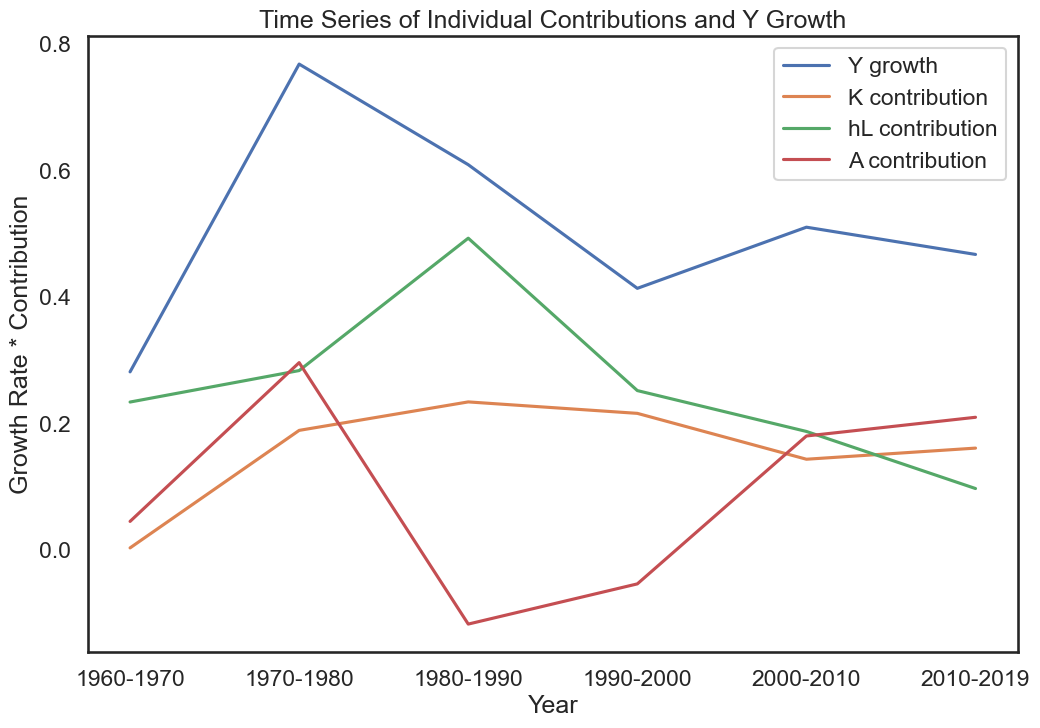

In [13]:
# Growth Accounting

# Ensure the year column is of integer type
data_indonesia_b["year"] = data_indonesia_b["year"].astype(int)

# Create a new column 'hL' that is labour multiplied by hc
data_indonesia_b["hL"] = data_indonesia_b["emp"] * data_indonesia_b["hc"]

# Display the updated DataFrame
display(data_indonesia_b)

# Initialise dataframe with NaNs
avg_growth_rates = pd.DataFrame(
    data = np.full((6, 4), np.nan),
    columns = ['Y growth', 'K growth', 'hL growth', 'A growth']
)
avg_growth_rates['year'] = ["1960-1970", "1970-1980", "1980-1990", "1990-2000", "2000-2010", "2010-2019"]
avg_growth_rates = avg_growth_rates.set_index('year')

# Set alpha = 0.3 
alpha = 0.3 

# Fill with average growth rates from data_indonesia_b
cols = ['rgdpna', 'rnna', 'hL', 'TFP_alpha_0.3']

# Ensure the years exist in the DataFrame
years = [1960, 1970, 1980, 1990, 2000, 2010, 2019]
for start, end in zip(years[:-1], years[1:]):
    if start in data_indonesia_b["year"].values and end in data_indonesia_b["year"].values:
        avg_growth_rates.loc[f"{start}-{end}"] = np.log(data_indonesia_b.loc[data_indonesia_b["year"] == end, cols].values / data_indonesia_b.loc[data_indonesia_b["year"] == start, cols].values).flatten()

# Compute contribution rates
df_contribs_long = avg_growth_rates.copy()
df_contribs_long['K contribution'] = alpha * (df_contribs_long['K growth'] / df_contribs_long['Y growth'])
df_contribs_long['hL contribution'] = (1 - alpha) * (df_contribs_long['hL growth'] / df_contribs_long['Y growth'])
df_contribs_long['A contribution'] = (1 - alpha) * (df_contribs_long['A growth'] / df_contribs_long['Y growth'])

# Only keep selected columns
df_contribs_long = df_contribs_long[['Y growth', 'K contribution', 'hL contribution', 'A contribution']]

# Calculate the proportions of each contribution to Y growth
df_contribs_long['K contribution proportion'] = df_contribs_long['K contribution'] * df_contribs_long['Y growth']
df_contribs_long['hL contribution proportion'] = df_contribs_long['hL contribution'] * df_contribs_long['Y growth']
df_contribs_long['A contribution proportion'] = df_contribs_long['A contribution'] * df_contribs_long['Y growth']

# Display the updated DataFrame
display(df_contribs_long)

# Plotting the time series
plt.figure(figsize=(12, 8))

# Plot Y growth
plt.plot(df_contribs_long.index, df_contribs_long['Y growth'], label='Y growth')

# Plot K contribution
plt.plot(df_contribs_long.index, df_contribs_long['K contribution proportion'], label='K contribution')

# Plot hL contribution
plt.plot(df_contribs_long.index, df_contribs_long['hL contribution proportion'], label='hL contribution')

# Plot A contribution
plt.plot(df_contribs_long.index, df_contribs_long['A contribution proportion'], label='A contribution')

# Adding titles and labels
plt.title('Time Series of Individual Contributions and Y Growth')
plt.xlabel('Year')
plt.ylabel('Growth Rate * Contribution')
plt.legend()

# Display the plot
plt.show()

### **3.4 Labour Productivity**

Labour productivity, measured as GDP per worker, was calculated to track economic efficiency. 

A time series plot compares labour productivity with Total Factor Productivity (TFP) to show their trends over time in Indonesia's growth.


,year,labour_productivity
0,1960,5176.994487
1,1961,5493.653960
2,1962,5390.918783
3,1963,5093.090400
4,1964,5237.664368
5,1965,5207.356698
6,1966,5259.641941
7,1967,5238.231084
8,1968,5503.067434
9,1969,5440.910861


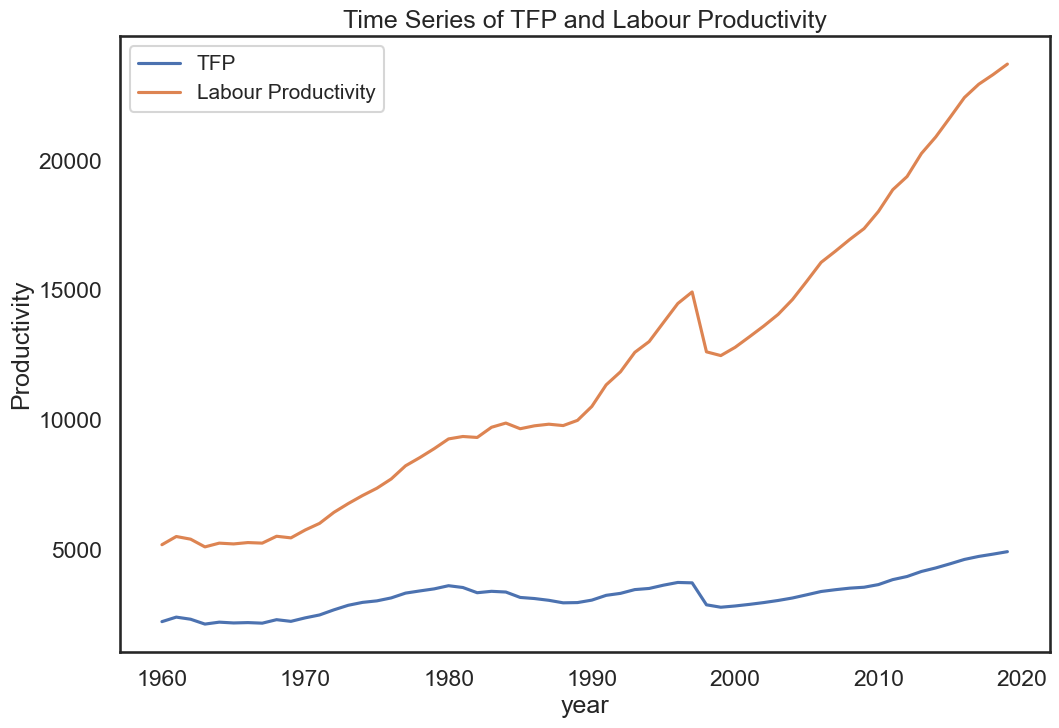

In [11]:
# Labour Productivity 
# Calculate labor productivity (GDP per worker)
data_indonesia_b["labour_productivity"] = data_indonesia_b["rgdpna"] / data_indonesia_b["emp"]

# Display the updated DataFrame
display(data_indonesia_b[["year", "labour_productivity"]])

# Plot Time Series with larger figure size
plt.figure(figsize=(12, 8))  # Adjust the figsize to make the graph bigger
plt.plot(data_indonesia_b['year'], data_indonesia_b["TFP_alpha_0.3"], label="TFP")
plt.plot(data_indonesia_b['year'], data_indonesia_b["labour_productivity"], label="Labour Productivity")

# Labels
plt.xlabel("year")
plt.ylabel("Productivity")
plt.legend(fontsize='small', loc='upper left')  # Slightly larger font size for better readability

# Title
plt.title("Time Series of TFP and Labour Productivity")

# Explicitly render the plot
plt.show()
